In [1]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import rescale, resize, radon, iradon
from skimage.filters import gaussian, threshold_otsu
import scipy

In [2]:
def plot(plots, figsize=(10,10)):
    plt.figure(figsize=figsize)
    z = zip(plots)
    a = len(plots)
    b = list(range(a))
    for i in range(a):
        n = next(z)
        plt.subplot(int((a/2)*100+21+b[i]))
        snr = np.mean(n[0])/np.std(n[0])
        plt.title('SNR = ' + str(snr)[0:5])
        plt.imshow(n[0])

def threshold_plot(plot, amount):
    plot = plot - (np.mean(plot)-np.std(plot)/amount)
    plot = np.asarray([0 if i <0 else i for i in plot])
    return plot

def add_noise(array, mean, std, multiplier):
    noise = np.random.normal(mean,std ,array.shape)*multiplier
    array = array+noise-np.min(noise)
    array = array-np.min(array)
    return array

# Initialize Phantom

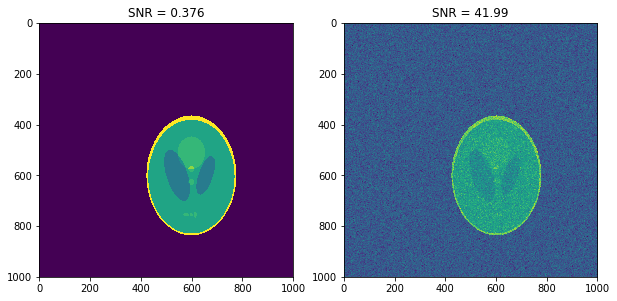

In [4]:
imshape = 1000
im = (imshape,imshape)
offset = 100
posa = int(imshape/2)-int(512/2)+offset
posb = int(imshape/2)+int(512/2)+offset

#Load Shepp Logan Phantom
slp = np.asarray(plt.imread('./pictures/Shepp-Logan_Phantom.tif')[:,:], dtype= float)

#Creat space for offsetting phantom
phantom=np.zeros(im)
phantom[posa:posb,posa:posb] = slp
#phantom = slp[106:406,106:406]


#create stack
phantom_stack = np.zeros(phantom.shape)
for i in range(300):
    phantom_stack = phantom_stack + add_noise(phantom, np.mean(phantom),np.std(phantom), 10)

phantom_noise = add_noise(phantom, np.mean(phantom),np.std(phantom), 10)
    
plot((phantom, phantom_stack))

# Generate Sinogram

In [5]:
#Generate sinogram
Circle = False
theta = np.linspace(0., 360., 360, endpoint=False)
sinogram = radon(phantom, theta=theta, circle=Circle)

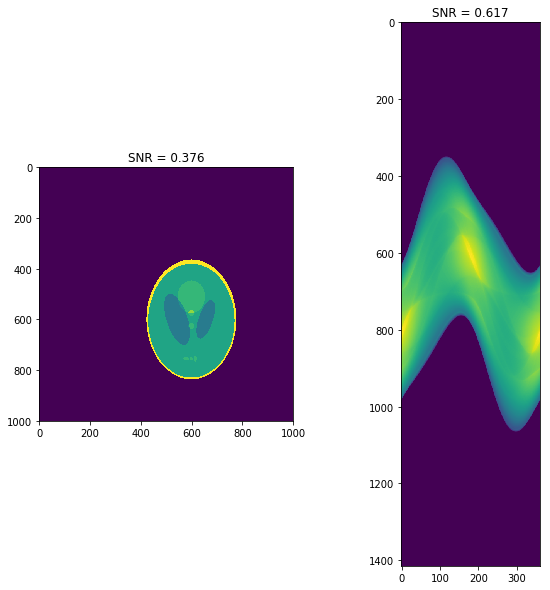

In [6]:
plot((phantom, sinogram))

In [7]:
#shift sinogram so rotation center is off of image center and add noise
sinogram_shift = np.zeros((sinogram.shape[0]*2,sinogram.shape[1]))
sinogram_shift[0:sinogram.shape[0],:] = sinogram
#sinogram_shift = sinogram#gaussian(sinogram_shift,.5)

# add noise
sinogram_shift = add_noise(sinogram_shift,np.mean(sinogram),np.std(sinogram), 10)

/home/everett/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


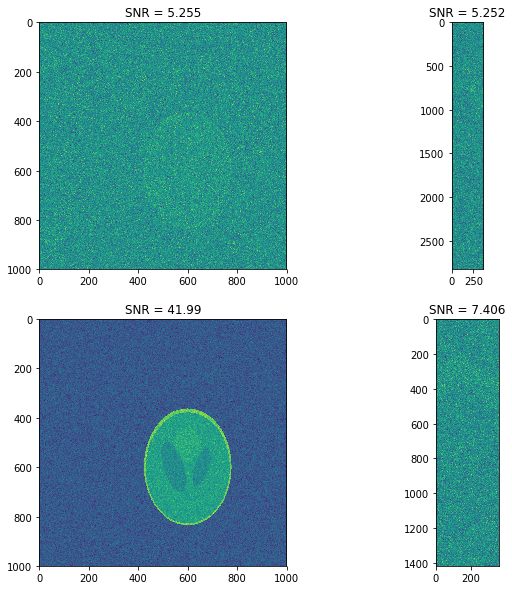

In [8]:
#Mess around with increasing dynamic range
sinogram_resized = resize(sinogram_shift, (int(sinogram_shift.shape[0] / 2), int(sinogram_shift.shape[1] / 1)), clip=False)

plot((phantom_noise, sinogram_shift, phantom_stack, sinogram_resized))
snr_resized = np.mean(sinogram_resized)/np.std(sinogram_resized)

/home/everett/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


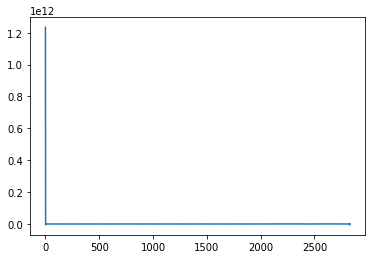

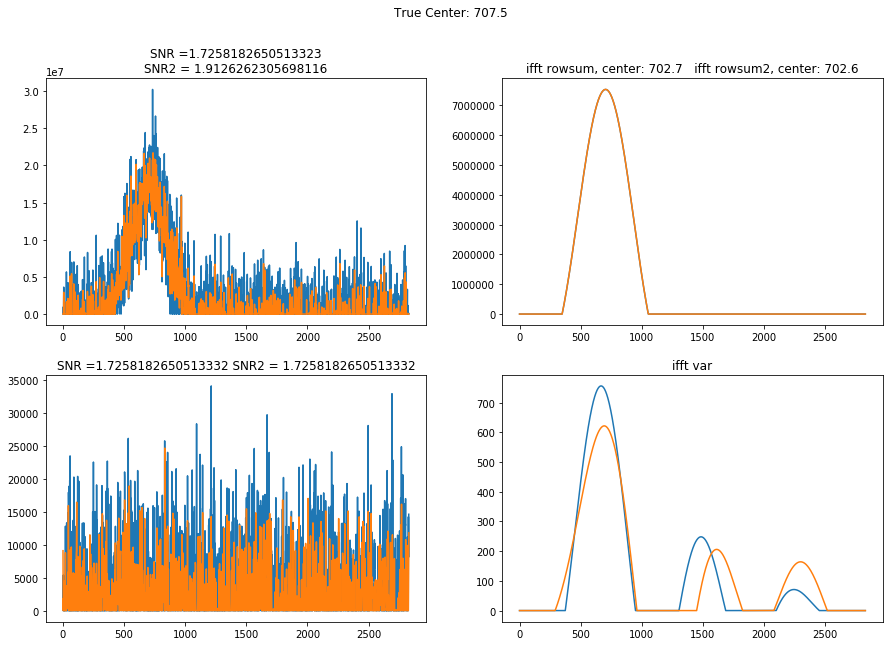

In [9]:
#sum projections from sinogram to find rotation center (sym center)
threshold_amount = 10 #increase threshold to remove off-feature noise
fft_cutoff = 5 #decrease fft cutoff to reduce high frequencies

rowsum = threshold_plot(np.sum(sinogram_shift, axis=1),threshold_amount)
var = threshold_plot(np.std(sinogram_shift, axis=1),threshold_amount)
mean = threshold_plot(np.mean(sinogram_shift, axis=1),threshold_amount)


#sum for interpolated image
rowsum2 = threshold_plot(np.sum(sinogram_resized, axis=1),threshold_amount)
var2 = threshold_plot(np.std(sinogram_resized, axis=1),threshold_amount)
mean2 = threshold_plot(np.mean(sinogram_resized, axis=1),threshold_amount)

#fft for row sum
fft = np.fft.fft(np.sum(sinogram_shift, axis=1))
plt.plot(fft)
plt.show()
fft[fft_cutoff:]=0
ifft = threshold_plot(np.fft.ifft(fft),threshold_amount)

fft2 = np.fft.fft(np.sum(sinogram_resized, axis=1))
fft2[fft_cutoff:]=0
ifft2 = threshold_plot(np.fft.ifft(fft2),threshold_amount)

#fft for variance
fftv = np.fft.fft(np.std(sinogram_shift, axis=1))
fftv[fft_cutoff:]=0
ifftv = threshold_plot(np.fft.ifft(fftv),threshold_amount)

fftv2 = np.fft.fft(np.std(sinogram_resized, axis=1))
fftv2[fft_cutoff:]=0
ifftv2 = threshold_plot(np.fft.ifft(fftv2),threshold_amount)

r = np.linspace(0,sinogram_shift.shape[0],sinogram_resized.shape[0])

if Circle == False:
    true_center = sinogram.shape[0]/2
else:
    true_center = imshape/2

plt.figure(figsize=(15,10))
plt.suptitle('True Center: ' + str(true_center))
plt.subplot(222)
plt.title('ifft rowsum, center: ' + 
          str(scipy.ndimage.measurements.center_of_mass(np.abs(ifft))[0]/len(ifft)*sinogram_shift.shape[0])[0:5] +
         '   ifft rowsum2, center: ' +
          str(scipy.ndimage.measurements.center_of_mass(np.abs(ifft2))[0]/len(ifft2)*sinogram_shift.shape[0])[0:5])
plt.plot(ifft)
plt.plot(r,ifft2)

plt.subplot(221)
plt.title('SNR ='+ str(np.std(rowsum)/np.mean(rowsum)) + '\nSNR2 = '+ str(np.std(rowsum2)/np.mean(rowsum2)))
plt.plot(rowsum)
plt.plot(r,rowsum2)

plt.subplot(223)
plt.title('SNR ='+ str(np.std(mean)/np.mean(mean)) + ' SNR2 = '+ str(np.std(mean)/np.mean(mean)))
plt.plot(var)
plt.plot(r, var2)

plt.subplot(224)
plt.title('ifft var')
plt.plot(ifftv)
plt.plot(r, ifftv2)

plt.show()

# Reaquire Center of Rotation


In [100]:
#Calculate Center of Mass

#threshold the plots
'''
rowsum = threshold_plot(np.sum(sinogram_shift, axis=1))
var = threshold_plot(np.std(sinogram_shift, axis=1))
mean = threshold_plot(np.mean(sinogram_shift, axis=1))

rowsum2 = threshold_plot(np.sum(sinogram_resized, axis=1))
var2 = threshold_plot(np.std(sinogram_resized, axis=1))
mean2 = threshold_plot(np.mean(sinogram_resized, axis=1))
'''
print('True Center ', sinogram_shift.shape[0]/2)
print('var ', scipy.ndimage.measurements.center_of_mass(var)[0]/len(var)*sinogram_shift.shape[0])
print('var2 ', scipy.ndimage.measurements.center_of_mass(var2)[0]/len(var2)*sinogram_shift.shape[0])
print('rowsum ', scipy.ndimage.measurements.center_of_mass(rowsum)[0]/len(rowsum)*sinogram_shift.shape[0])
print('rowsum2 ', scipy.ndimage.measurements.center_of_mass(rowsum2)[0]/len(rowsum2)*sinogram_shift.shape[0])
print('ifft ', scipy.ndimage.measurements.center_of_mass(np.abs(ifft))[0]/len(ifft)*sinogram_shift.shape[0])
print('ifftv2 ', scipy.ndimage.measurements.center_of_mass(np.abs(ifftv))[0]/len(ifftv)*sinogram_shift.shape[0])

True Center  1415.0
var  1367.8290298108004
var2  1317.1569728316379
rowsum  941.9479351697363
rowsum2  861.3790004605415
ifft  707.5309193911241
ifftv2  923.6463666599323


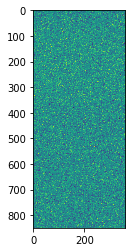

In [395]:
com = int(scipy.ndimage.measurements.center_of_mass(np.abs(ifft))[0]/len(ifft)*2000)

adj_sino = sinogram_shift[0:1000,:]
plt.imshow(adj_sino)
plt.show()

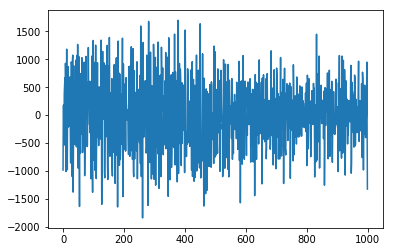

In [118]:
# Aquire center of rotation and align  
plt.plot(np.gradient(var2))
plt.show()

In [26]:
# inverse radon to reconstruct
recon = iradon(sinogram, theta=theta,circle=True)

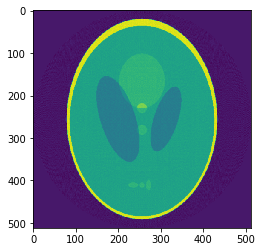

In [27]:
plt.imshow(recon)
plt.show()